<body>
    <h1>NER System for Few-NERD</h1>
    <img src="https://www.labellerr.com/blog/content/images/2024/01/ner-1.webp" alt="Few-nerd dataset" width="500px">
    <p>Leveraging Gemini API to analyze different Named Entity Recognition techniques for general purpose Few-NERD Dataset</p>
</body>

# NLP Project - 2025

**Authors:** Manuel Antonutti and Alessandro Viespoli

**Course of Study:** Computer Engineering

**Work Enviroment:** Google Colab

In [ ]:
%%capture
!pip install -U datasets
!pip install -q nltk matplotlib google-genai python-dotenv

In [ ]:
%matplotlib inline

The following libraries were used for the project:

- datasets: Download Few-NERD dataset
- nltk: Used for computing pos-tags
- matplotlib: Needed for plotting dataset metrics
- google-genai: To configure Gemini client and send requests
- python-dotenv: Used to read enviroment files

## Constants

In this project we chose the `gemini-2.0-flash` and `gemini-2.0-flash-lite` models for making the API calls because of the followings:
1. **Ease of use**: the overall experience from prompt creation and API integration was less tedious and more humanly readable compared to other models.

2. **Accessibility**: no need for powerful hardware/GPUs, making us believe this was the right choice for the purpose of a NER system.

3. **Structured output**: very few free LLM API offered structured JSON outputs

The main drawback of this choice was the limited amount of calls that could be made in just one day, however it was a great opportunity to learn how to make API request and how to handle the rate limit.

In [ ]:
CHATBOT_MODEL_GEMINI_DEV = "models/gemini-2.0-flash-lite"
CHATBOT_MODEL_GEMINI_TEST = "models/gemini-2.0-flash"

MAX_RPM_DEV = 30                # Maximum requests per minute for the development model
MAX_RPM_TEST = 15               # Maximum requests per minute for the testing model

DATASET = "DFKI-SLT/few-nerd"
DEV_SIZE = 5
TRAIN_SIZE = 5                  # Samples for few-shot technique
TEST_SIZE = 100
WORKING_SET = "test"            # Partition of the dataset from which to take the data

Our decision to employ two distinct models was driven by two strategic considerations:
1. It helped us work around the [daily request limit](https://ai.google.dev/gemini-api/docs/rate-limits?hl=en) (approximately 1,500) imposed by the API.
2. This approach allowed us to implement a cost-effective experimentation methodology: we could initially use the more light/economical model to identify and refine techniques, before validating our findings with the more larger/expensive model. This two-tiered approach enabled efficient resource allocation while maintaining the integrity of our project.
3. For the final notebook run, we inverted this strategy: we used the more capable model (`gemini-2.0-flash`) for the development section and the faster model (`gemini-2.0-flash-lite`) for the testing section. This allowed us to trade off our accuracy (less than 5%) for a significant gain in speed, cutting our run time in half.

In [ ]:
import os
import sys
import time
from collections import Counter, deque

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk import pos_tag

import datasets
from huggingface_hub import login as hugging_login
from google import genai
from google.genai.types import Tool, GenerateContentConfig, GoogleSearch

from dotenv import load_dotenv
from pydantic import BaseModel

## Downloading the dataset





Given the project's constraints of utilizing zero-shot or few-shot techniques, we made a strategic decision to move away from specialized datasets, which needed fine-tuning to reach acceptable performance metrics.

We opted for [Few-Nerd](https://arxiv.org/abs/2105.07464), a human-crafted **general-purpose** dataset in order to test LLM models on a much broader range of topics, rather than being limited to narrow, domain-specific applications.

The dataset was downloaded from [hugging face](https://huggingface.co/datasets/DFKI-SLT/few-nerd), where a much detailed description of the dataset structure can be found.

In [ ]:
hugging_login()

In [ ]:
dataset = datasets.load_dataset(DATASET, "supervised")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.13k [00:00<?, ?B/s]

few-nerd.py:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/2.43M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/4.84M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/131767 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/18824 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/37648 [00:00<?, ? examples/s]

## Dataset Analysis


Few-NERD dataset contains four main fields:
- **id** : string identifier
- **tokens** :  a list tokens in the sentence
- **ner_tags** : coarse-grained entity labels
- **fine_ner_tags** : fine-grained entity labels

The **ner_tags** field uses 9 possible labels ranging from 0-8, representing:
0. O
1. art
2. building
3. event
4. location
5. organization
6. other
7. person
8. product

For this project we decided to not use the **fine_ner_tags** since there are very specialized label that are harder to be detected.

In [ ]:
dataset_not_split = datasets.concatenate_datasets([dataset['train'], dataset['validation'], dataset['test']])

total_samples = len(dataset_not_split)
print(f"Total number of samples: {total_samples}")

total_tokens = sum(len(sample['tokens']) for sample in dataset_not_split)
print(f"Total number of tokens: {total_tokens}")
print(f"Average tokens per sample: {total_tokens/total_samples:.2f}")

Total number of samples: 188239
Total number of tokens: 4611895
Average tokens per sample: 24.50


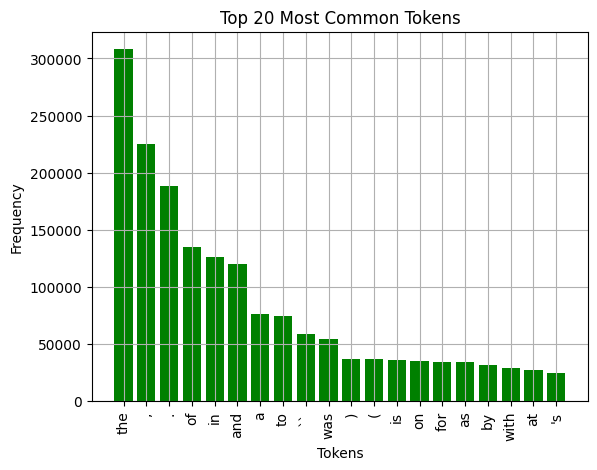

In [ ]:
# Word frequency distribution (top 20 words)
all_tokens = [token.lower() for sample in dataset_not_split for token in sample['tokens']]
common_tokens = Counter(all_tokens).most_common(20)
tokens, counts = zip(*common_tokens)

plt.bar(tokens, counts, color='green')
plt.title('Top 20 Most Common Tokens')
plt.xticks(rotation=90)
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Helper Functions and Classes

### NERPredictor Class
To remove duplicated code and make testing easier, we introduce an **OOP styled predictor class** to more easily and reliably interact with the generative models.
This class effectively utilizes the **Strategy design pattern**. It establishes the input data as the fixed context, allowing various NER techniques (strategies) to be interchanged seamlessly. This helps in following the **DRY** (Don't Repeat Yourself) principle and writing more maintainable code.

Description of each method:
- `configure(self, new_technique)` : allows to switch between different prediction techniques of the entities
- `predict()` : calls the technique (strategy) on each one of the input sentences

In [ ]:
class NERPredictor:
    def __init__(self, model, client, rate_limiter, label_set, input_sentences):
        self.client = client                      # Gemini client
        self.model = model                        # Model name of the LLM, must be a gemini model that allows structured output
        self.label_set = label_set
        self.input_sentences = input_sentences
        self.rate_limiter = rate_limiter          # RateLimiter object to limit the model API calls
        self.technique = None                     # Function defining a NER technique


    def configure(self, new_technique):
        if not callable(new_technique):
            raise ValueError("New technique must be callable.")
        self.technique = new_technique

    def predict(self, **kwargs):
        if self.technique is None:
            raise ValueError("No technique configured.")

        predictions = []
        for i, input_text in enumerate(self.input_sentences):
            print("=================================")
            print(f"Executing Sentence: {input_text}")

            curr_kwargs = {
              key: value[i] if isinstance(value, list) else value
              for key, value in kwargs.items()
            }

            prediction = self.technique(self, input_text, self.label_set, **curr_kwargs)

            predictions.append(prediction)

        print("")
        return predictions

### RateLimiter Class
To avoid going over the API calls rate limit, we introduce a simple rate limiter class. Every time the wait() method is called, it checks the requests made in the last minute and if they have reached the RPM limit, it will put the process to sleep for a few seconds. This method needs to be called before each remote API call to the LLM.

Description of each method:
- `wait()` : wait for a few seconds if the rate limit has been reached, otherwise return immediately

In [ ]:
class RateLimiter:
    def __init__(self, rpm: int):
        self.rpm = rpm                        # Requests per minute
        self.interval_seconds = 60 / rpm      # Time allowed per request
        self.requests = deque()               # Stores timestamps of recent requests

    def wait(self):
        now = time.monotonic()

        # Clean up old requests (older than 60 seconds)
        while self.requests and self.requests[0] <= now - 60:
            self.requests.popleft()

        # If we have reached the RPM limit within the last minute, calculate how long we need to wait.
        if len(self.requests) >= self.rpm:
            # The oldest request in the current window determines when we can make the next
            # We add 60 seconds to its timestamp to get the "release time" for the window.
            oldest_request_time = self.requests[0]
            wait_until = oldest_request_time + 60
            sleep_duration = wait_until - now

            if sleep_duration > 0:
                time.sleep(sleep_duration)
                # After sleeping, update 'now' to reflect the current time
                now = time.monotonic()
                self.requests.append(now)
                return
            else:
                # No sleep needed, but we still append the current request
                self.requests.append(now)
                return
        else:
            # If we haven't reached the RPM limit yet, no waiting is needed.
            self.requests.append(now)
            return

### Rate Limited API Calls
The following functions call the APIs, making sure to limit the requests rate and implementing a retry logic in case the response is not valid:

- `rate_limited_call(...)` : sends a standard single request
- `rate_limited_chat(...)` : sends a chat message and keeps track of a conversation spanning multiple messages (sends the previous chat history to the remote LLM at each request).
- `rate_limited_search_call(...)` : sends a single request, while making use of Google's search tool to ground the result with online data.

By setting the temperature to zero for all the API calls we managed to get deterministic responses from the LLMs.

In [ ]:
def rate_limited_call(context, message, response_schema):
    """ Sends one message to the model API with rate limiting and retries on invalid responses.

        Args:
          context:          A NERPredictor object (used as context to get model, client and rate_limiter)
          message:          The message to send.
          response_schema:  The schema for the response. (i.e. list[Entity])

        Returns:
          The text response from the model API if successful, '[]' otherwise after max retries.
    """
    retries = 0
    max_retries = 5
    response = None
    while response is None and retries < max_retries:
        try:
            # Limit the API calls rate
            context.rate_limiter.wait()

            # Send message and request a response in the given format
            response = client.models.generate_content(
                model=context.model,
                contents=message,
                config={
                    "response_mime_type": "application/json",
                    "response_schema": response_schema,
                    "temperature" : 0,
                },
            )

        except genai.errors.ClientError as e:
            # If the client is getting rate limited, read the 429 retryDelay time and wait accordingly
            print(f"-- ClientError occured: {e}.")
            response = None
            if e.code == 429:
                retries += 1

                # Look for retryDelay in the json message
                retry_delay = None
                details = e.details.get('error', {}).get('details', [])
                for detail in details:
                    if detail.get('@type') == 'type.googleapis.com/google.rpc.RetryInfo':
                        retry_delay = detail.get('retryDelay')

                if retry_delay:
                    print(f"-- The retryDelay is: {retry_delay}. Retrying...")
                    time.sleep(int(retry_delay.replace('s', '')))
                else:
                    print("-- No retry delay found. Retrying...")

            time.sleep(5)

        except Exception as e:
            print(f"-- Exception occured: {e}. Retrying...")
            response = None
            retries += 1
            time.sleep(1)


    if response is None:
        print("-- Max retries reached. Returning empty list.")
        return []
    parsed_response = response.parsed
    print(f"-- Response: {parsed_response}")
    return parsed_response

In [ ]:
def rate_limited_chat(context, message, response_schema, chat):
    """ Sends a message to the chat API with rate limiting and retries on invalid responses.

        Args:
          context:          A NERPredictor object (used as context to get the rate_limiter).
          message:          The message to send.
          response_schema:  The schema for the response. (i.e. list[Entity])
          chat:             The client.chat object that keeps the conversation history

        Returns:
          The text response from the chat API if successful, '[]' otherwise after max retries.
    """
    retries = 0
    max_retries = 5
    response = None
    while response is None and retries < max_retries:
        try:
            # Limit the API calls rate
            context.rate_limiter.wait()

            # Send message and request a response in json format as a list of Entities
            response = chat.send_message(
                message,
                config={
                    "response_mime_type": "application/json",
                    "response_schema": response_schema,
                    "temperature" : 0,
                },
            )

        except genai.errors.ClientError as e:
            # If the client is getting rate limited, read the 429 retryDelay time and wait accordingly
            print(f"-- ClientError occured: {e}.")
            response = None
            if e.code == 429:
                retries += 1

                # Look for retryDelay in the json message
                retry_delay = None
                details = e.details.get('error', {}).get('details', [])
                for detail in details:
                    if detail.get('@type') == 'type.googleapis.com/google.rpc.RetryInfo':
                        retry_delay = detail.get('retryDelay')

                if retry_delay:
                    print(f"-- The retryDelay is: {retry_delay}. Retrying...")
                    time.sleep(int(retry_delay.replace('s', '')))
                else:
                    print("-- No retry delay found. Retrying...")

            time.sleep(5)

        except Exception as e:
            response = None
            retries += 1
            print(f"-- Exception occured: {e}. Retrying...")
            time.sleep(1)

    if response is None:
        print("-- Max retries reached. Returning empty list.")
        return []
    parsed_response = response.parsed
    print(f"-- Response: {parsed_response}")
    return parsed_response

In [ ]:
def rate_limited_search_call(context, message):
    """ Sends a message to the model API with rate limiting and retries on invalid responses.
        It makes use of Google's search tool to ground the result with online data.
        It does not support a response schema, because google search tool and structured output are incompatible.

        Args:
          context: A NERPredictor object (used as context to get model, client and rate_limiter)
          message: The message to send.

        Returns:
          The text response from the model API if successful, '[]' otherwise after max retries.
    """
    # Prepare google search tool config
    google_search_tool = Tool(google_search = GoogleSearch())

    retries = 0
    max_retries = 5
    response = None
    while response is None and retries < max_retries:
        try:
            # Limit the API calls rate
            context.rate_limiter.wait()

            # Send message and request a response with google search grounding
            response = client.models.generate_content(
                model=context.model,
                contents=message,
                config=GenerateContentConfig(
                    tools=[google_search_tool],
                    response_modalities=["TEXT"],
                    temperature=0,
                )
            )

        except genai.errors.ClientError as e:
            # If the client is getting rate limited, read the 429 retryDelay time and wait accordingly
            print(f"-- ClientError occured: {e}.")
            response = None
            if e.code == 429:
                retries += 1

                # Look for retryDelay in the json message
                retry_delay = None
                details = e.details.get('error', {}).get('details', [])
                for detail in details:
                    if detail.get('@type') == 'type.googleapis.com/google.rpc.RetryInfo':
                        retry_delay = detail.get('retryDelay')

                if retry_delay:
                    print(f"-- The retryDelay is: {retry_delay}. Retrying...")
                    time.sleep(int(retry_delay.replace('s', '')))
                else:
                    print("-- No retry delay found. Retrying...")

            time.sleep(5)

        except Exception as e:
            response = None
            retries += 1
            print(f"-- Exception occured: {e}. Retrying...")
            time.sleep(1)

    if response is None:
        print("-- Max retries reached. Returning empty list.")
        return []

    print(f"-- Response: {response.text}")
    return response.text

### Metrics Computation Pipeline
This section implements the evaluation pipeline for our NER techniques.

Since the majority of the tokens are labeled as "O", indicating non-entities, we optimize our approach by having models return only the actual named entities. This makes the responses more efficient, as we can safely assume that any token not explicitly predicted is a non-entity.

The code processes these predictions, aligns them with true labels, and computes standard performance metrics. This allows us to quantitatively assess how well our different NER techniques identifies and classifies named entities in the text.

#### **Issues with the evaluation**

During our experimentation, we identified two significant issues that impact the accurate evaluation of our LLM's performance.

As an example consider this sentence: *In the early 1930s the band moved to the Grill Room of the Taft Hotel in New York; the band was renamed \`\` George Hall and His Hotel Taft Orchestra \`\`.*

- **1)** The first major challenge is sequence alignment between the input sentence tokens and the entities generated by the LLM. The LLM's output can present inconsistencies such as out of order entities, missing or additional tokens.

  These inconsistencies complicate the computation of evaluation metrics, as it becomes difficult to precisely match the golden labels with the LLM's output labels for comparison.

  Some of the LLM outputs presented:
  - Out of order tokens in the output
  - Missing tokens (e.g. removing some prepositions or special characters)
  - Duplicated tokens (e.g. returning both `George Hall` and then `George Hall and His Hotel Taft Orchestra`)

- **2)** The second critical issue is related to the LLM's span boundary detection. The model occasionally fails to accurately delineate the precise start and end points of an entity. This can result in either under-detection (missing parts of an entity), over-detection (including extraneous tokens), or an inability to correctly handle nested entities.

  For instance, it happened that `George Hall` was classified as `'person'` when it should have been identified as part of `George Hall and His Hotel Taft Orchestra` as `'organization'`).

#### **Metrics**

To compute the metrics we decided to use two approaches, the first was inspired by this [paper](https://www.google.com/url?q=https%3A%2F%2Faclanthology.org%2F2025.coling-main.345%2F) where they use an
entity-level micro-F1 score. Both the entity boundary and entity type must be
correctly predicted. (e.g. in the previous example sentence we have the golden labels represented as {`New York`:`location`} instead of [{`New`: `location`}, {`York`: `location`}] ).

Recognizing that the initial approach was too strict and unforgiving, we decided to work on matching the labels at the token level, by splitting the entities into single tokens (e.g. in the previous example sentence we have the golden labels represented as [{`New`: `location`}, {`York`: `location`}] instead of {`"New York"`:`location`} ). This enables a more precise and robust evaluation of the results.

In the end, for completeness, we display the metrics (accuracy, precision, recall and F1-score) for both approaches.


In [ ]:
def entity_separator(model_predictions):
    """ Splits multi-token entity predictions into individual token predictions.

        Args:
          model_predictions: List of lists containing Entity objects with potentially multi-token predictions

        Returns:
          List of lists containing Entity objects with single-token predictions
    """
    return [[Entity(token=token, label=entity.label) for entity in response for token in entity.token.split()]
              for response in model_predictions]


def compute_labels_for_metrics(model_predictions, true_label_sets):
    """ Aligns model predictions and true labels for metric computation, filling missing predictions with 'O' and reducing
        lists dimensions from 2 to 1 for faster metrics computation.

        Args:
          model_predictions:  List of lists containing predicted Entity objects for each sentence
          true_label_sets:    List of lists containing true Entity objects for each sentence

        Returns:
          - true_labels: List of true labels in sequence
          - pred_labels: List of predicted labels in sequence, with 'O' for missing predictions
    """
    true_labels = []
    pred_labels = []

    for i, true_entities_in_sentence in enumerate(true_label_sets):
        current_sentence_model_preds = []
        if i < len(model_predictions): # Ensure that model_predictions[i] exists to avoid errors if sentences are missing.
            current_sentence_model_preds = list(model_predictions[i])

        for entity in true_entities_in_sentence:
            true_labels.append(entity.label)
            predicted_label = 'O'  # Default to 'O'
            found_match_idx = -1

            # Try to find the current true_entity.token in the remaining model predictions for this sentence
            for pred_idx, model_pred_entity in enumerate(current_sentence_model_preds):
                if entity.token == model_pred_entity.token:
                    predicted_label = model_pred_entity.label
                    found_match_idx = pred_idx
                    break

            if found_match_idx != -1:
                current_sentence_model_preds.pop(found_match_idx)

            pred_labels.append(predicted_label)

    return true_labels, pred_labels


def entity_aggregator(token_entities):
    """ Aggregates a list of single-token Entity objects into a list of consolidated Entity objects based on their NER labels.

        Args:
            token_entities (list[Entity]):  A list of Entity objects, where each object
                                            represents a single token and its associated label.

        Returns:
            list[Entity]: A list of aggregated Entity objects, where tokens of the
                          same entity are combined into a single 'token' string.
    """
    if not token_entities:
        return []

    aggregated_entities = []
    current_entity_tokens = []
    current_entity_label = None
    for i, entity_obj in enumerate(token_entities):
        token = entity_obj.token
        label = entity_obj.label

        if label != 'O':
            if current_entity_label is None or label == current_entity_label:
                # Continue building the current entity
                current_entity_tokens.append(token)
                current_entity_label = label
            else:
                # A new entity type started, or current one ended
                if current_entity_tokens:
                    aggregated_entities.append(
                        Entity(token=' '.join(current_entity_tokens), label=current_entity_label)
                    )
                # Start a new entity
                current_entity_tokens = [token]
                current_entity_label = label
        else:
            if current_entity_tokens:
                # The previous sequence of tokens formed an entity, so save it
                aggregated_entities.append(
                    Entity(token=' '.join(current_entity_tokens), label=current_entity_label)
                )
                # Reset for the next potential entity
                current_entity_tokens = []
                current_entity_label = None

    if current_entity_tokens:
        aggregated_entities.append(
            Entity(token=' '.join(current_entity_tokens), label=current_entity_label)
        )

    return aggregated_entities


def match_entities_for_metrics(model_predictions, true_label_sets):
    """ Compares predicted entities to true entities to prepare data for metric calculation.

        Args:
            model_predictions:  List of lists containing predicted Entity objects for each sentence
            true_label_sets:    List of lists containing true Entity objects for each sentence

        Returns:
            - true_labels: List of true labels in sequence
            - pred_labels: List of predicted labels in sequence, with 'O' for missing predictions
    """
    pred_labels = []
    true_labels = []

    for predictions, solutions in zip(model_predictions, true_label_sets):
        for pred_entity in predictions:
            matched_flag = False
            for i, sol_entity in enumerate(solutions):
                if pred_entity.token == sol_entity.token:
                    solutions.pop(i)
                    matched_flag = True
                    break  # Move to the next prediction after removing the match
            if not matched_flag:
                pred_labels.append(pred_entity.label)
                true_labels.append('NO MATCHING')
            else:
                pred_labels.append(pred_entity.label)
                true_labels.append(sol_entity.label)
        for sol_entity in solutions:
            pred_labels.append('NO MATCHING')
            true_labels.append(sol_entity.label)

    return true_labels, pred_labels


def plot_confusion_matrix(y_true, y_pred, labels):
    """ Creates and displays a confusion matrix.

        Args:
          y_true: List of true labels
          y_pred: List of predicted labels
          labels: List of label names to be displayed on both axes
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(5,5))
    cm_masked = np.ma.masked_where(cm == 0, cm)
    cm_log = np.log10(cm + 1)  # Avoid log(0)

    sns.heatmap(cm_log, annot=cm, fmt='d', xticklabels=labels, yticklabels=labels,
                cmap='Blues', cbar_kws={'label': 'log10(c + 1)'})
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


def compute_metrics(model_predictions, true_label_sets) :
    """ Calculates and displays performance metrics for NER predictions.

      Args:
          model_predictions:    List of lists containing predicted Entity objects
          true_label_sets:      List of lists containing true Entity objects from the dev set
    """
    temp_true_label_sets = []
    for true_label_set in true_label_sets:
        temp_true_label_sets.append(entity_aggregator(true_label_set))

    true_labels, pred_labels = match_entities_for_metrics(model_predictions, temp_true_label_sets)

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average='weighted')

    print("METRICS (boundary level comparison):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")


    model_predictions = entity_separator(model_predictions)
    true_labels, pred_labels = compute_labels_for_metrics(model_predictions, true_label_sets)

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average='weighted')

    print("\nMETRICS (token level comparison):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("")

    plot_confusion_matrix(true_labels, pred_labels, label_set)

## Analysis Preparations - Dataset Preprocessing




To ensure consistency and clarity in our analysis, we've implemented a structured output format using the Entity class, which inherits from the `pydantic` BaseModel class.

This standardization necessitated the alignment of the dataset's original gold labels with our Entity class structure.

In [ ]:
class Entity(BaseModel):
    token: str
    label: str


def prepare_true_label_sets(input_list, golden_labels, dataset_ner_tags):
    """ Converts input tokens and their labels into Entity objects.

        Args:
            input_list:       List of input tokens
            golden_labels:    List of numeric label indices
            dataset_ner_tags: List of NER tag strings corresponding to numeric indices

        Returns:
            List of Entity objects, each containing a token and its corresponding NER label
    """
    true_label_dict = []
    for i in range(len(input_list)):
        true_label_dict.append(Entity(token=input_list[i], label=dataset_ner_tags[golden_labels[i]]))
    return true_label_dict

Before diving deep into the analysis of each technique, it's essential to establish the fundamental variables required for our experiments.

During development we took many decisions, but the following are worth an explanation:
- Given the API call limitations and the substantial dataset size of 188,239 sentences, we strategically selected the test set as our `WORKING_SET`, which has better labeling overall: subsequently we divided it into development and test sets for proper evaluation.

- Reconstructing sentences accurately from individual tokens proved to be challenging. After exploring various solutions, we determined that the `TreebankWordDetokenizer` from `NLTK` provided the optimal balance between implementation simplicity and natural language output. While this approach proved effective, it's worth noting its limitations in handling quote spacing. Despite these minor constraints, this preprocessing framework established a solid foundation for our subsequent analysis.

In [ ]:
# Extract the list of ner tags from the dataset
label_set = dataset[WORKING_SET].features["ner_tags"].feature.names

# Create human-like sentences from the dataset tokens
tokenized_input_sentences = dataset[WORKING_SET]["tokens"][:DEV_SIZE+TEST_SIZE+TRAIN_SIZE]
detokenizer = TreebankWordDetokenizer()
input_sentences = [detokenizer.detokenize(sample) for sample in tokenized_input_sentences]
input_sentences_dev, input_sentences_test, input_sentences_train = input_sentences[:DEV_SIZE], input_sentences[DEV_SIZE:DEV_SIZE+TEST_SIZE], input_sentences[DEV_SIZE+TEST_SIZE:]

# Extract golden_labels from the dataset and convert the ner_tags from numbers to "categories"
golden_labels = [sample for sample in dataset[WORKING_SET]["ner_tags"][:DEV_SIZE+TEST_SIZE+TRAIN_SIZE]]
true_labels = [prepare_true_label_sets(tokenized_input_sentences[i], golden_labels[i], label_set) for i in range(DEV_SIZE+TEST_SIZE+TRAIN_SIZE)]
true_labels_dev, true_labels_test, true_labels_train = true_labels[:DEV_SIZE], true_labels[DEV_SIZE:DEV_SIZE+TEST_SIZE], true_labels[DEV_SIZE+TEST_SIZE:]

print(f"\nLabel Set: {label_set}\n")
print(f"+++ Example +++")
print(f"Tokens:             {tokenized_input_sentences[0]}")
print(f"Cleaned Input Text: {input_sentences[0]}")
print(f"Golden Labels:      {golden_labels[0]}")
print(f"True Label Set:     {true_labels[0]}")


Label Set: ['O', 'art', 'building', 'event', 'location', 'organization', 'other', 'person', 'product']

+++ Example +++
Tokens:             ['In', 'the', 'early', '1930s', 'the', 'band', 'moved', 'to', 'the', 'Grill', 'Room', 'of', 'the', 'Taft', 'Hotel', 'in', 'New', 'York', ';', 'the', 'band', 'was', 'renamed', '``', 'George', 'Hall', 'and', 'His', 'Hotel', 'Taft', 'Orchestra', '``', '.']
Cleaned Input Text: In the early 1930s the band moved to the Grill Room of the Taft Hotel in New York; the band was renamed "George Hall and His Hotel Taft Orchestra ".
Golden Labels:      [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 4, 4, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 0, 0]
True Label Set:     [Entity(token='In', label='O'), Entity(token='the', label='O'), Entity(token='early', label='O'), Entity(token='1930s', label='O'), Entity(token='the', label='O'), Entity(token='band', label='O'), Entity(token='moved', label='O'), Entity(token='to', label='O'), Entity(token='the', label='O'), En

In order to get better results for the decomposed technique we resorted to providing **definitions of each label** during prompting. The idea was inspired by this [paper](https://www.google.com/url?q=https%3A%2F%2Faclanthology.org%2F2025.coling-main.345%2F) and suggested that giving the LLM a general idea of what a label represents increased its performance. The paper also presented a methodology to automatically generate the definitions based on a technique they called self-summarization, but due to the complexity of its implementation, we simply decided to manually prepare them ourselves using the examples in the [Few-NERD paper](https://www.google.com/url?q=https%3A%2F%2Farxiv.org%2Fabs%2F2105.07464).



In [ ]:
# Definitions for each of the labels in label_set
label_definitions = {}
label_definitions['location'] = "Any fixed point or area on Earth," + \
" including geopolitical entities, bodies of water, islands, mountains," + \
" parks, roads/transit routes, and other specific geographical places."
label_definitions['person'] = "An individual human, identified by name," + \
" associated with roles like Actor, Artist/Author, Athlete, Director, Politician, Scholar, or Soldier."
label_definitions['organization'] = "A group of people with a particular purpose, such as a Company," + \
" Educational institution, Government body, Media outlet, Political/party, Religion group,"+ \
" Sports League, or Sports Team."
label_definitions['building'] = "A structure with a roof and walls, such as an Airport,"+ \
" Hospital, Hotel, Library, Restaurant, Sports Facility, or Theater."
label_definitions['art'] = "A creative work or expression, including Music, Film,"+ \
" Written Art, Broadcast, Painting, or other artistic forms."
label_definitions['product'] = "An item created or manufactured, such as an Airplane, Car, Food, Game, Ship, Software,"+ \
" Train, Weapon, or other manufactured goods."
label_definitions['event'] = "An occurrence or happening, such as an Attack, Election,"+ \
" Natural Disaster, Protest, Sports Event, or other notable occurrence."
label_definitions['other'] = "A broad category for entities that don't fit into more specific named entity types,"+ \
"including concepts like Astronomy, Award, Biology, Chemistry, Currency, Disease, Educational Degree,"+ \
" God, Language, Law, Medical or Animal Species."

# Setting up Gemini API
In order to use the Gemini API service, it is necessary to have a personal key. Follow this steps in order to create one:
- Go to https://ai.google.dev/gemini-api/docs/api-key
- Click on the blue button "Get a Gemini API key in Google AI Studio"
- On the top-right click on "Create API key"
- Search for "Gemini API" and create
- Copy your API key and paste it in the variable ```your_api_key_here``` **(IMPORTANT)**


In [ ]:
#=====================================#
# IMPORTANT: insert your API key here #
#=====================================#
your_api_key_here = ""

# Create the api_key.env if not found
if not os.path.exists('api_key.env'):
    print("api_key.env file not found. Creating new file...")
    try:
        with open('api_key.env', 'w') as f:
            f.write(f"GEMINI_API_KEY={your_api_key_here}\n")
    except Exception as e:
        print(f"Error creating api_key.env file: {str(e)}")
        sys.exit(1)

# Load api key from env file and configure setup
load_dotenv('api_key.env')
gemini_api_key = os.getenv('GEMINI_API_KEY')

# Configure gemini client
client = genai.Client(api_key=gemini_api_key,
                      http_options=genai.types.HttpOptions(timeout=30000))

Let's check if the setup was done right by creating a simple test query

In [ ]:
prompt_example = """Given entity label set: {label_set}
Based on the given entity label set, please recognize the named entities in the given
text.
Text: {input_text}
"""

print(f"Input sentence: {input_sentences_dev[0]}")

# Insert input data into the prompt
prompt_example = prompt_example.format(label_set=label_set, input_text=input_sentences_dev[0])

# Send the request, asking for a structured output in response
response = client.models.generate_content(
    model=CHATBOT_MODEL_GEMINI_DEV,
    contents=prompt_example,
    config={
        "response_mime_type": "application/json",
        "response_schema": list[Entity],
    },
)

# Parse and print the response
parsed_response = response.parsed
print(f"Response: {parsed_response}")

Input sentence: In the early 1930s the band moved to the Grill Room of the Taft Hotel in New York; the band was renamed "George Hall and His Hotel Taft Orchestra ".
Response: [Entity(token='early', label='other'), Entity(token='1930s', label='other'), Entity(token='band', label='organization'), Entity(token='Grill Room', label='building'), Entity(token='Taft Hotel', label='building'), Entity(token='New York', label='location'), Entity(token='band', label='organization'), Entity(token='George Hall', label='person'), Entity(token='Hotel Taft Orchestra', label='organization')]


# NER Techniques
This section will showcase the development and a small evaluation of the following techniques:
- Vanilla
- Decomposed QA
- Tool Augmentation
- Vanilla + Online search
- Vanilla + Chain of Thought
- Vanilla + Iterative refinement
- Few-shot

NOTE: given the very small development set of samples used in this section, the metrics presented are only slightly indicative of the real performance of the techniques, and should be taken with a grain of salt.


But first let's define the RateLimiter and NERPredictor objects that we'll use throughout the entire development process


In [ ]:
rate_limiter_dev = RateLimiter(MAX_RPM_DEV)

predictor_dev = NERPredictor(model=CHATBOT_MODEL_GEMINI_DEV,
                             client=client,
                             rate_limiter=rate_limiter_dev,
                             label_set=label_set,
                             input_sentences=input_sentences_dev)

## Vanilla technique
This is the most basic approach presented in the [paper](https://www.google.com/url?q=https%3A%2F%2Farxiv.org%2Fabs%2F2310.10035). It just provides the `label_set` and an `input_text` to the LLM and asks to recognize the entities. We took the provided prompt template and added two instructions to enhance it:

- In order to make the process faster we require the LLM to only return the named entities and ignore all the tokens without a label (e.g. verbs, prepositions, articles that would be tagged as `'O'`).

- By specifying to return entities composed of multiple tokens as a single block, we noticed a significant improvement in the ability of the LLM to identify these bigger groups of tokens as part of a single entity (e.g. it recognizes the band {`"George Hall and His Taft Hotel Orchestra"`: `'organization'`}, instead of splitting it into {`"George Hall"`: `'person'`} and {`"Taft Hotel Orchestra"`: `'organization'`}.

In [ ]:
def vanilla_technique(context, input_text, label_set):
    prompt_vanilla = """Given entity label set: {label_set}
    Based on the given entity label set, please recognize the named entities in the given text.

    Text: {input_text}

    **Instructions**:
    If you find an entity composed of multiple words, return it as a single entity token.
    Return only the entities whose label is not O, in the same order as they are encountered in the sentence
    """

    message = prompt_vanilla.format(label_set=label_set, input_text=input_text)
    # Send the message
    response = rate_limited_call(context, message, list[Entity])

    return response

Executing Sentence: In the early 1930s the band moved to the Grill Room of the Taft Hotel in New York; the band was renamed "George Hall and His Hotel Taft Orchestra ".
-- Response: [Entity(token='Taft Hotel', label='building'), Entity(token='New York', label='location'), Entity(token='George Hall and His Hotel Taft Orchestra', label='organization')]
Executing Sentence: The final season of minor league play Elkin Memorial Park saw season attendance of 16,322, an average of 299 per contest.
-- Response: [Entity(token='Elkin Memorial Park', label='location')]
Executing Sentence: They finished the season 14–19, 9–9 in C-USA play to finish in seventh place.
-- Response: [Entity(token='C-USA', label='organization')]
Executing Sentence: The B-52 pilot, Major Larry G. Messinger, later recalled,
-- Response: [Entity(token='B-52', label='product'), Entity(token='Major Larry G. Messinger', label='person')]
Executing Sentence: The Austro-Hungarian Navy built and operated two classes of protected 

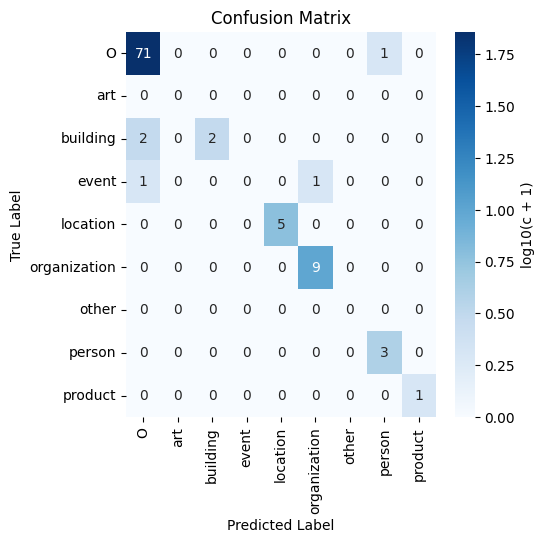

In [ ]:
# Configure strategy and prompt template
predictor_dev.configure(vanilla_technique)

# Retrieve predictions
predictions = predictor_dev.predict()
print(f"Final predictions:\n{predictions}\n")
compute_metrics(predictions, true_labels_dev)

## Decomposed technique

This is the second approach taken from the [paper](https://www.google.com/url?q=https%3A%2F%2Farxiv.org%2Fabs%2F2310.10035). The technique revolves around decomposing the NER task into several question answering requests, where the LLM is asked to find all entities of one label category at a time.

Our implementation of the technique makes use of the Gemini **message chat API**, that automatically saves the history of a conversation with the remote LLM and attaches it to the start of each new request.

In our function, the conversation starts with a generic task description and then proceeds to run each label tagging question one by one. At the end, we ask the model to aggregate all the results from the previous rounds in one answer and return the ordered structured output. In total, it takes 10 prompts per sentence (one for each of the 8 NER labels plus 2 for start/end prompts).

In [ ]:
def decomposed_technique(context, input_text, label_set):
    prompt_decomposed_start = """You are a NER assistant.
    Input text will follow for specific entity extraction.
    """

    prompt_decomposed = """Please identify all entities of type {label}.
    {label} is defined as: {label_definition}

    Text: {input_text}

    Task:
      1. Identify all entities of type '{label}'.
      2. Review previous labels: If an entity also fits '{label}', or if a previous label seems incorrect given the focus on '{label}', update accordingly.
    If you find an entity composed of multiple words, return it as a single entity. If no entities are found, return nothing.
    """

    prompt_decomposed_end = """Final Review & Output:
    1. Consolidate all identified entities, choose one label per entity.
    2. Order by appearance in the original text.
    3. Perform a final accuracy check:
        - Correct any misclassifications based on all definitions.
        - Ensure label consistency.
        - Remove any false positives (non-entities).
    Return the complete, ordered, and verified list of entities.
    """

    # Start a chat with the model (to keep the context of the whole conversation)
    chat = client.chats.create(model=context.model)

    # Send starting message
    response = rate_limited_chat(context, prompt_decomposed_start, str, chat)

    for label in label_set:
        if label != "O":
            print(f"-- Searching for label '{label}'")
            message = prompt_decomposed.format(label=label, input_text=input_text,
                                               label_set=label_set, label_definition=label_definitions[label])
            response = rate_limited_chat(context, message, list[Entity], chat)

    # Send ending message
    response = rate_limited_chat(context, prompt_decomposed_end, list[Entity], chat)
    return response

Executing Sentence: In the early 1930s the band moved to the Grill Room of the Taft Hotel in New York; the band was renamed "George Hall and His Hotel Taft Orchestra ".
-- Response: string
-- Searching for label 'art'
-- Response: [Entity(token='Orchestra', label='art')]
-- Searching for label 'building'
-- Response: [Entity(token='Hotel', label='building'), Entity(token='Taft Hotel', label='building')]
-- Searching for label 'event'
-- Response: []
-- Searching for label 'location'
-- Response: [Entity(token='New York', label='location')]
-- Searching for label 'organization'
-- Response: [Entity(token='George Hall and His Hotel Taft Orchestra', label='organization')]
-- Searching for label 'other'
-- Response: []
-- Searching for label 'person'
-- Response: [Entity(token='George Hall', label='person')]
-- Searching for label 'product'
-- Response: []
-- Response: [Entity(token='Taft Hotel', label='building'), Entity(token='New York', label='location'), Entity(token='George Hall', lab

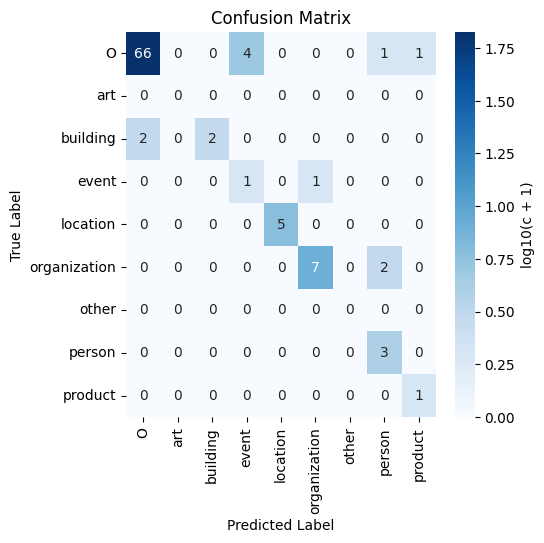

In [ ]:
# Configure strategy and prompt template
predictor_dev.configure(decomposed_technique)

# Retrieve predictions
predictions = predictor_dev.predict()
print(f"Final predictions:\n{predictions}\n")
compute_metrics(predictions, true_labels_dev)

## Tool Augmentation
This is the fourth approach taken from the [paper](https://www.google.com/url?q=https%3A%2F%2Farxiv.org%2Fabs%2F2310.10035).  The technique description is very similar to the decomposed technique with the only difference being that the part-of-speech
tags have been calculated and appended to the prompt.

So, first we need to retrieve the POS tags from each sentence. Starting by downloading the necessary packages needed by `nltk`

In [ ]:
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
def get_pos_tags(tokenized_input_sentences) :
  pos_tags = []
  for tokens in tokenized_input_sentences :
    pos_tags.append(nltk.pos_tag(tokens))

  return pos_tags

def attach_pos_tags_pairs(pos_tags) :
  return [" ".join([f"{token}/{tag}" for token, tag in pos_tag]) for pos_tag in pos_tags]

In [ ]:
pos_tags_pairs = get_pos_tags(tokenized_input_sentences)
pos_tags = attach_pos_tags_pairs(pos_tags_pairs)
pos_tags_dev, pos_tags_test = pos_tags[:DEV_SIZE], pos_tags[DEV_SIZE:TEST_SIZE]

In [ ]:
def tool_augmentation_technique(context, input_text, label_set, pos_tags):
    prompt_tool_augmentation_start = """During the following conversation you will be tasked to solve a
    NER tagging problem by returning the entities of one category label at a time, keep in mind to only return the entities
    pertaining to that specific category label at each step, except for the last message in which I will explicitly ask you to return
    all the labeled entities together."""

    prompt_tool_augmentation = """Given entity label set: {label_set}
    Given the text and the corresponding Part-of-Speech tags, your goal is to find
    named entities of the specific label provided in the question for the given text.

    Text: {input_text}

    Part-of-Speech tags: {pos_tags}

    Question: What are the named entities labeled as '{target_label}' in the text?"""

    prompt_tool_augmentation_end = """Now return all previous entities in a single answers.
    Return the labeled entities ordered by their appearence in the input text."""

    # Start a chat with the model (to keep the context of the whole conversation)
    chat = client.chats.create(model=context.model)

    # Send starting message
    response = rate_limited_chat(context, prompt_tool_augmentation_start, str, chat)

    for label in label_set:
        if label != "O":
            print(f"-- Searching for label '{label}'")
            message = prompt_tool_augmentation.format(label_set=label_set, input_text=input_text,
                                                pos_tags=pos_tags, target_label=label)
            response = rate_limited_chat(context, message, list[Entity], chat)

    # Send ending message
    response = rate_limited_chat(context, prompt_tool_augmentation_end, list[Entity], chat)
    return response

Executing Sentence: In the early 1930s the band moved to the Grill Room of the Taft Hotel in New York; the band was renamed "George Hall and His Hotel Taft Orchestra ".
-- Response: string
-- Searching for label 'art'
-- Response: []
-- Searching for label 'building'
-- Response: [Entity(token='Grill Room', label='building'), Entity(token='Taft Hotel', label='building')]
-- Searching for label 'event'
-- Response: []
-- Searching for label 'location'
-- Response: [Entity(token='New York', label='location')]
-- Searching for label 'organization'
-- Response: [Entity(token='George Hall and His Hotel Taft Orchestra', label='organization')]
-- Searching for label 'other'
-- Response: []
-- Searching for label 'person'
-- Response: [Entity(token='George Hall', label='person')]
-- Searching for label 'product'
-- Response: []
-- Response: [Entity(token='Grill Room', label='building'), Entity(token='Taft Hotel', label='building'), Entity(token='New York', label='location'), Entity(token='Geor

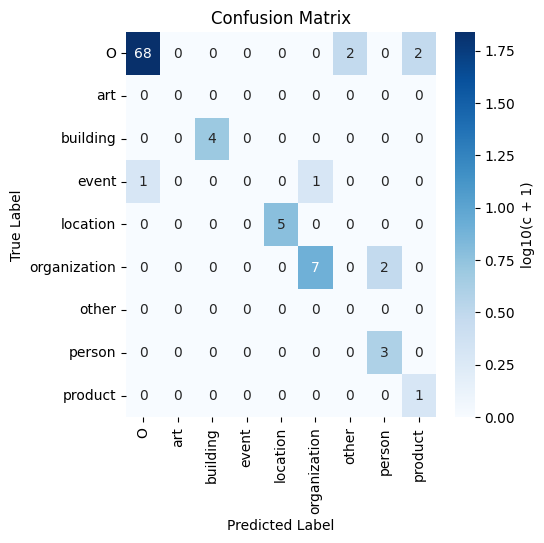

In [ ]:
# Configure strategy and prompt template
predictor_dev.configure(tool_augmentation_technique)

# Retrieve predictions
predictions = predictor_dev.predict(pos_tags=pos_tags_dev)
print(f"Final predictions:\n{predictions}\n")
compute_metrics(predictions, true_labels_dev)

## Vanilla + Online search (grounding)
In this approach we decided to try the **Google search tool** provided by Gemini to better understand the entities based on online data. The idea is to first lookup the entities and their possible interpretations (e.g. Washington could be either a 'person' or a 'location') via Google search and then insert the augmented information into the vanilla prompt.

In our implementation we had to make three API requests instead of one, because there is a technical constraint with the Gemini API. It currently doesn't permit using its integrated tools alongside requests for structured JSON output. To work around this, we implemented a three-step process: first, we ask the LLM to extract as many entities as it can, no matter how ambiguous they are. Then, using Google search, we look up each entity and their possible interpretations, and finally we feed that augmented data into a third prompt to get our desired results.

In [ ]:
def vanilla_online_search_technique(context, input_text, label_set):
    prompt_find_entities = """Identify all potential entities within the given input text: {input_text}

    **Instructions:**
    1.  Process the input text thoroughly.
    2.  Identify all clear entities according to the definition.
    3.  Identify all words or tokens that might be entities, even if the likelihood is low. These are your ambiguous entities.
    4.  Return both clear entities and ambiguous entities as strings.
    """

    prompt_online_search = """Given input text: {input_text}.

    Given the following entities list: {entities}.

    **Instructions:**
    1.  Process the input text thoroughly.
    2.  Look up online all the given entities.
    3.  Look up online all the entities in the input text that are missing from the given entities list.
    4.  Return a very brief description (few words) of what each entity is.
    """

    prompt_vanilla = """Given entity label set: {label_set}
    Based on the given entity label set and the following online google search result, please recognize the named entities in the given text.

    Text: {input_text}

    Online search result: <<{online_result}>>

    **Instructions:**
    1.  If you find an entity composed of multiple words, return it as a single entity token.
    2.  Return only the entities whose label is not O, in the same order as they are encountered in the sentence.
    3.  If the entities in the online search result are not relevant, do not return them.
    """

    # Send message to find all potential entities
    message = prompt_find_entities.format(input_text=input_text)
    response = rate_limited_call(context, message, list[str])

    # Take the previous response and perform online search
    message = prompt_online_search.format(input_text=input_text, entities=str(response))
    response = rate_limited_search_call(context, message)

    # Use previous results and perfom vanilla request
    message = prompt_vanilla.format(label_set=label_set, input_text=input_text,
                                  online_result=response)
    response = rate_limited_call(context, message, list[Entity])

    return response

Executing Sentence: In the early 1930s the band moved to the Grill Room of the Taft Hotel in New York; the band was renamed "George Hall and His Hotel Taft Orchestra ".
-- Response: ['1930s', 'Grill Room', 'Taft Hotel', 'New York', 'George Hall and His Hotel Taft Orchestra']
-- Response: Okay, I will process the input text, look up the provided entities and search for any missing entities online, and then provide a brief description of each.

Here are brief descriptions of the entities:

*   **1930s:** A decade marked by the Great Depression.
*   **Grill Room:** A dining room or restaurant, in this case, located within the Taft Hotel.
*   **Taft Hotel:** A former hotel in New York City, now a condominium and hotel.
*   **New York:** A major city in the United States.
*   **George Hall and His Hotel Taft Orchestra:** A popular band in the 1930s.

-- Response: [Entity(token='Taft Hotel', label='building'), Entity(token='New York', label='location'), Entity(token='George Hall and His Hote

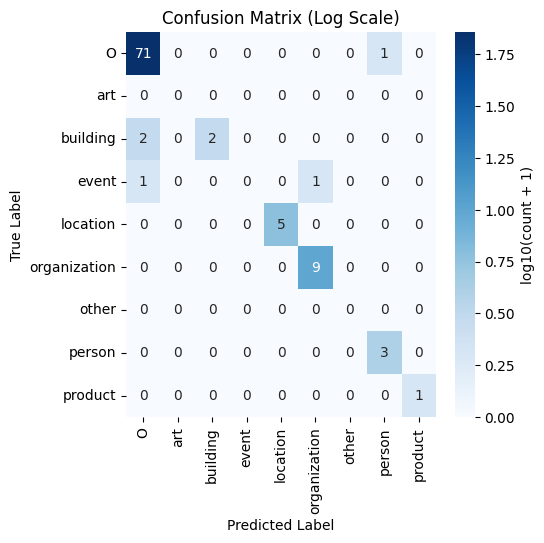

In [ ]:
# Configure strategy and prompt template
predictor_dev.configure(vanilla_online_search_technique)

# Retrieve predictions
predictions = predictor_dev.predict()
print(f"Final predictions:\n{predictions}\n")
compute_metrics(predictions, true_labels_dev)

## Vanilla + Chain of Thought

In this section, we employed a Chain of Thought (CoT) approach, where we attempted to improve results by adding extensive instructions and increasing the length and complexity of our prompt template.

During experimentation we noticed vastly different results between various configurations, even for rather small changes to the instructions list. This is probably due to the very small set of samples used in this chapter.

In [ ]:
def vanilla_chain_of_thought_technique(context, input_text, label_set):
    prompt_vanilla = """Given entity label set: {label_set}
    Based on the given entity label set, please recognize the named entities in the given text.

    Text: {input_text}

    **Instructions**:
    1) Strict Label Adherence: Only assign labels that are explicitly present in the label_set. If a segment of text could be an entity but its type is not in the label_set, do not tag it.
    2) Exact Text Span and Punctuation:
        - Extract the most precise and minimal text span that constitutes the entity.
        - Do not include leading or trailing whitespace, punctuation (e.g., periods, commas, question marks, exclamation marks) unless that punctuation is an integral and inseparable part of the entity's official name (e.g., "O'Malley," "Ph.D.").
        - For entities within parentheses or quotes, only extract the entity itself, not the surrounding punctuation.
        - If an entity is followed by a possessive "'s", exclude the "'s" unless the label definition explicitly includes possessives. (e.g., "John's book" -> tag "John" as PERSON).
        - If you find an entity composed of multiple words, return it as a single entity token (e.g., "New York City" is one LOCATION entity).
    3) Case Sensitivity: Preserve the original casing of the entity text as it appears in the input_text.
    4) Overlapping Entities: If entities overlap, include all valid overlapping entities. For example, if "New York University" is an ORGANIZATION and "New York" is a LOCATION, and both labels are in the label_set, then both entities should be tagged. Prioritize the most specific or longest valid span where applicable.
    5) Contextual Disambiguation: Always use the surrounding words and sentences to accurately disambiguate entities. For instance, "Apple" could be an ORGANIZATION or a PRODUCT (fruit); the context will determine the correct label. If context is insufficient for a confident label, consider omitting the tag.
    6) Non-Entities (What NOT to Tag):
        - Do not tag common nouns, verbs, adjectives, adverbs, articles, conjunctions, or prepositions.
        - Do not resolve pronouns (e.g., "He," "She," "It," "They") to their antecedents; only tag explicit named entity mentions.
        - Do not tag generic titles (e.g., "CEO," "President," "Doctor") unless they are part of a full named entity span (e.g., "Apple CEO Tim Cook" where "Tim Cook" is PERSON and potentially "Apple CEO Tim Cook" is an ORGANIZATION_ROLE if in label set).
        - Return only the entities whose label is not 'O' (Outside of an entity).
    7) Completeness & Order: Strive to identify all instances of entities that match the provided label_set within the input_text. Return entities in the same order as they are encountered in the sentence, based on their start_offset.
    8) No Redundancy: Avoid tagging the exact same text span with the exact same label multiple times.
    9) Numerical and Temporal Entities (if applicable in label_set):
        - For DATE, TIME, MONEY, PERCENT, QUANTITY (if included in label_set), identify the full numerical or temporal expression.
        - Be precise with boundaries: "On December 25, 2023, I bought two apples for $1.50."
        - Differentiate between a generic number (e.g., "I have 5 fingers") and a numerical entity (e.g., "Flight BA249 arrived at Gate 10").
    10) Handling Ambiguity/Uncertainty: If an entity is highly ambiguous and cannot be confidently assigned a label from the label_set even with strong contextual cues, it is preferable to omit it entirely rather than risking an incorrect label or span. Err on the side of precision over recall when confidence is low.
    11) If you find an entity composed of multiple words, return it as a single entity token.
    12) Return only the entities whose label is not O, in the same order as they are encountered in the sentence.

    **Chain of thought**:
    1) Identify all possible entities (look for capitalized words or find them by the context around them).
    2) Infer the Part-of-Speech (POS) tags for each token and use it to better understand each entity.
    3) Look for entities for each entity label one by one. Follow this order: {label_set}
    4) Choose one single label per token.
    5) Aggregate tokens from the same entity together. Always prioritize bigger entities over smaller ones.
    6) Remove redundancies, there should only one label per entity. Having an entity inside another is not allowed.
    7) Return the complete, ordered, and verified list of entities. Keep out the non-entities labeled 'O'.
    8) Repeat steps 1 through 7 again for five times and keep only the entities that appeared in the majority of the runs.
    """
    label_defs = ""
    for i, label in enumerate(label_set):
        if label != "O":
            label_defs += f"\t{i}) {label}: \n{label_definitions[label]}\n"

    message = prompt_vanilla.format(label_set=label_set, input_text=input_text,
                                    label_definitions=label_defs)

    # Send the message
    response = rate_limited_call(context, message, list[Entity])

    return response

Executing Sentence: In the early 1930s the band moved to the Grill Room of the Taft Hotel in New York; the band was renamed "George Hall and His Hotel Taft Orchestra ".
-- Response: [Entity(token='Grill Room', label='building'), Entity(token='Taft Hotel', label='building'), Entity(token='New York', label='location'), Entity(token='George Hall and His Hotel Taft Orchestra', label='organization')]
Executing Sentence: The final season of minor league play Elkin Memorial Park saw season attendance of 16,322, an average of 299 per contest.
-- Response: [Entity(token='Elkin Memorial Park', label='location')]
Executing Sentence: They finished the season 14–19, 9–9 in C-USA play to finish in seventh place.
-- Response: [Entity(token='C-USA', label='organization')]
Executing Sentence: The B-52 pilot, Major Larry G. Messinger, later recalled,
-- Response: [Entity(token='Larry G. Messinger', label='person')]
Executing Sentence: The Austro-Hungarian Navy built and operated two classes of protected

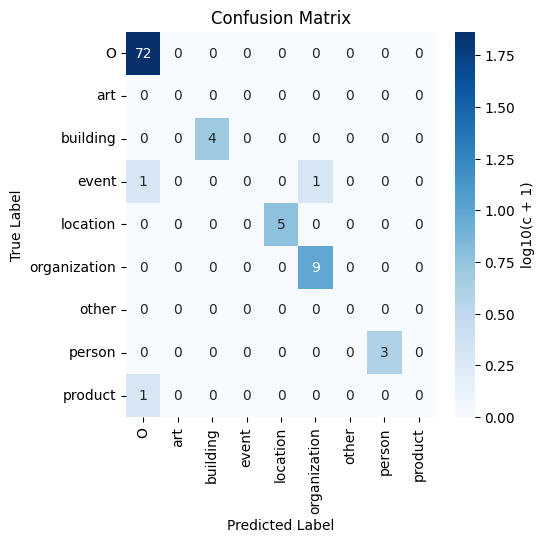

In [ ]:
# Configure strategy and prompt template
predictor_dev.configure(vanilla_chain_of_thought_technique)

# Retrieve predictions
predictions = predictor_dev.predict()
print(f"Final predictions:\n{predictions}\n")
compute_metrics(predictions, true_labels_dev)

## Vanilla + Iterative refinement

In this approach, we implemented a two-stage process to iteratively improve the vanilla prompt's initial output. In the first stage, we generate a baseline response, and in the second, we ask the LLM to refine it.

Although this technique is scalable to more iterations, two stages proved to be the optimal trade-off. It balances fast run times with good results. Also, it mitigates the risk of hallucinations, as they grow as more requests are made.

In [ ]:
def vanilla_iterative_refinement_technique(context, input_text, label_set):
    prompt_first_stage = """Given entity label set: {label_set}
    Based on the given entity label set, please recognize the named entities in the given text.

    Text: {input_text}

    **Instructions**:
    If you find an entity composed of multiple words, return it as a single entity.
    Return only the entities whose label is not O, in the same order as they are encountered in the sentence
    Always return all entities in the input text. Favor the bigger entities as opposed to the smaller ones.
    """

    # Send first stage message
    message = prompt_first_stage.format(label_set=label_set, input_text=input_text)
    response = rate_limited_call(context, message, list[Entity])

    prompt_second_stage = """Refine the previos NER tagging attempt: {previous_attempt}

    Given entity label set: {label_set}

    Given labels definitions: {label_definitions}

    Given input text: {input_text}

    **Instructions**:
    1. Refine the previous attempt. Make sure the entity span boundary only contains tokens that are part of the entity.
    2. If you find an entity composed of multiple words, return it as a single entity.
    3. Return only the entities whose label is not O, in the same order as they are encountered in the sentence.
    4. Always return all entities in the input text. Favor the bigger entities as opposed to the smaller ones.
    """

    # Send second stage message, with previous informations added
    message = prompt_second_stage.format(label_set=label_set, input_text=input_text,
                                         previous_attempt=str(response), label_definitions=label_definitions)
    response = rate_limited_call(context, message, list[Entity])

    return response

Executing Sentence: In the early 1930s the band moved to the Grill Room of the Taft Hotel in New York; the band was renamed "George Hall and His Hotel Taft Orchestra ".
-- Response: [Entity(token='Grill Room', label='location'), Entity(token='Taft Hotel', label='building'), Entity(token='New York', label='location'), Entity(token='George Hall and His Hotel Taft Orchestra', label='organization')]
-- Response: [Entity(token='Grill Room', label='building'), Entity(token='Taft Hotel', label='building'), Entity(token='New York', label='location'), Entity(token='George Hall and His Hotel Taft Orchestra', label='organization')]
Executing Sentence: The final season of minor league play Elkin Memorial Park saw season attendance of 16,322, an average of 299 per contest.
-- Response: [Entity(token='Elkin Memorial Park', label='location')]
-- Response: [Entity(token='Elkin Memorial Park', label='location')]
Executing Sentence: They finished the season 14–19, 9–9 in C-USA play to finish in seventh 

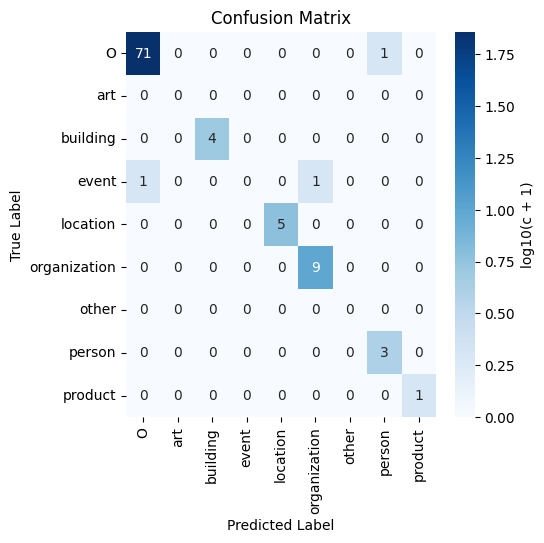

In [ ]:
# Configure strategy and prompt template
predictor_dev.configure(vanilla_iterative_refinement_technique)

# Retrieve predictions
predictions = predictor_dev.predict()
print(f"Final predictions:\n{predictions}\n")
compute_metrics(predictions, true_labels_dev)

## Few-shot

For this next section, we employed a few-shot learning technique to guide the LLM. Our prompt started with the general task description, followed by several examples taken from a distinct portion of our dataset. These examples were given as a series of "Text:" and "Answer:" segments that demonstrated the desired output format (as a list of Entity objects). We then concluded the prompt by concatenating the new input text and instructing the LLM to generate its response based on these learned patterns.

In [ ]:
def few_shot_technique(context, input_text, label_set):
    prompt_few_shot = """Given entity label set: {label_set}
    Based on the given entity label set, please recognize the named entities in the given text.

    **Instructions**:
    1. If you find an entity composed of multiple words, return it as a single entity.
    2. Return only the entities whose label is not O, in the same order as they are encountered in the sentence.
    3. Always return all entities in the input text. Favor the bigger entities as opposed to the smaller ones.
    """

    # Create and append a few sentence examples to the message
    message = prompt_few_shot.format(label_set=label_set)
    for i, few_shot_example in enumerate(input_sentences_train):
        message += f"\nText: {few_shot_example}\nAnswer: {entity_aggregator(true_labels_train[i])}"
    message += f"**Answer the text**:\nText: {input_text}\nAnswer:"

    # Send the message
    response = rate_limited_call(context, message, list[Entity])

    return response

Executing Sentence: In the early 1930s the band moved to the Grill Room of the Taft Hotel in New York; the band was renamed "George Hall and His Hotel Taft Orchestra ".
-- Response: [Entity(token='Taft Hotel', label='building'), Entity(token='New York', label='location'), Entity(token='George Hall and His Hotel Taft Orchestra', label='organization')]
Executing Sentence: The final season of minor league play Elkin Memorial Park saw season attendance of 16,322, an average of 299 per contest.
-- Response: [Entity(token='Elkin Memorial Park', label='location')]
Executing Sentence: They finished the season 14–19, 9–9 in C-USA play to finish in seventh place.
-- Response: [Entity(token='C-USA', label='organization')]
Executing Sentence: The B-52 pilot, Major Larry G. Messinger, later recalled,
-- Response: [Entity(token='B-52', label='product'), Entity(token='Major Larry G. Messinger', label='person')]
Executing Sentence: The Austro-Hungarian Navy built and operated two classes of protected 

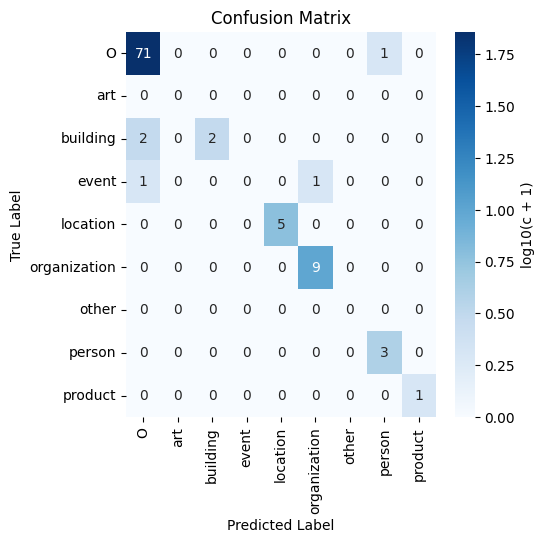

In [ ]:
# Configure strategy and prompt template
predictor_dev.configure(few_shot_technique)

# Retrieve predictions
predictions = predictor_dev.predict()
print(f"Final predictions:\n{predictions}\n")
compute_metrics(predictions, true_labels_dev)

## Additional experiments
In addition to the techniques presented above, we explored several experimental approaches and tests that ultimately didn't meet our performance expectations. This section briefly summarizes the most significant attempts and their results.

#### **Permutations of the label_set**

We investigated whether the order of labels within the prompt's `label_set` influenced performance. Surprisingly, label permutations significantly impacted the F1-score (token level) across all techniques, with results fluctuating from 0.80 to 0.95 even for small edits. Given the impracticality of testing all possible permutations (8! = 40,320), we focused on a select few that we thought made sense:

- `Alphabetical Order`: This is the original ordering taken from the dataset and yielded the best results for the simpler techniques (like Vanilla and Two-Stage).
- `Most Common Label (Descending)`: Ordering labels from most to least frequent ("person" to "other") consistently led to unimpressive performance (lower than alphabetical by around 3%) across most techniques.
- `Most Common Label (Ascending)`: Ordering labels from least to most frequent ("other" to "person") improved performance for decomposed and tool-augmented approaches. This can suggest that identifying rarer entities first may be easier than later. Additionally, if an LLM makes an initial labeling error, there's a high chance that the correct label is one of the more commmon ones, meaning that it will self-correct when it encounters them in a later request.

Ultimately, we adopted the **alphabetical ordering** and left the `label_set` untouched.

#### **Using more complex label descriptions for Decomposed**

When developing the decomposed technique, a natural progression was to improve the label descriptions. We attempted to provide more elaborate guidance, including specific characteristics to look for in the entities and common mislabeling pitfalls to watch out for. However, this approach didn't yield significantly different results compared to the basic decomposed technique. Therefore, we opted to just keep the simpler method.

In [ ]:
complex_label_descriptions = {}
complex_label_descriptions['art'] = """What to Look For:
    1. Titles of creations: Look for names that refer to specific movies, songs, albums, books, plays, stories, TV shows, radio programs, paintings, sculptures, visual art pieces, or live performances.
    2. Think of it as: "Is this a specific, named thing that someone created for artistic expression?"

    Don't tag:
    1. Specific, named items that are manufactured or offered for sale, use, or consumption. These are 'product'.
    2. Groups, bands and collections of people. These are 'organization'.
    3. General categories of art unless they are part of a specific title."""

complex_label_descriptions['product'] = """What to Look For:
    1. Named Items: Look for proper nouns that refer to specific models, brands, or unique instances of manufactured goods, consumer items, software, or vehicles. This includes things like:
    2. Think of it as: "Is this a specific, named item or service that is produced, bought, sold, or used?"

    Don't tag:
    1. Manufacturers or companies themselves. These are 'organization'.
    2. General categories of items unless they are part of a specific product name."""

complex_label_descriptions['person'] = """What to Look For:
    1. Named Individuals: Look for proper nouns that refer to specific human beings. This includes:
    - Full names of individuals.
    - First names or last names when the context clearly refers to a specific known individual.
    - Titles or roles when used as a primary identifier for a specific person (e.g., "Dr. Smith").
    - Figures recognized in various fields like art, politics, sports, or science.
    2. Think of it as: "Is this a specific, named human being?"

    Don't tag:
    1. Groups or collective entities of people. Terms that are part of a group name. These are 'organization'."""

complex_label_descriptions['location'] = """What to Look For:
    1. Named Places: Look for proper nouns that refer to specific geographical or geopolitical sites.
    2. Think of it as: "Is this a specific, named place or geographical area?"

    Don't tag:
    1. Buildings or structures (these are 'building').
    2. General geographical terms (e.g., "mountain," "river," "city") unless they are part of a specific named location."""

complex_label_descriptions['organization'] = """What to Look For:
    1. Named Groups or Entities: Look for proper nouns that refer to specific formal bodies, institutions, or collective entities. This includes things like:
    - Companies, corporations, or businesses.
    - Educational institutions (e.g., schools, universities).
    - Government bodies or agencies.
    - Media outlets (e.g., newspapers, broadcasters).
    - Political parties.
    - Religious groups or denominations.
    - Sports leagues or teams.
    - Organizations primarily involved in shows, music, or entertainment.
    - Foundations, non-profits, or other structured associations.
    2. Think of it as: "Is this a specific, named collective entity that operates as a unit?"

    Don't tag:
    1. General categories of groups (e.g., "school," "government," "team") unless they are part of a specific organization's name."""

complex_label_descriptions['building'] = """What to Look For:
    1. Named Structures: Look for proper nouns that refer to specific, permanent constructions designed for human activity, storage, or operation. This includes things like: airports, hospitals, hotels, libraries, restaurants, sports facilities, theaters, and other architectural structures.
    2. Think of it as: "Is this a specific, named man-made structure or facility?"

    Don't tag:
    1. Organizations or businesses that operate within a building, if the name refers primarily to the entity rather than the physical structure itself. These are 'organization'.
    2. General categories of structures unless they are part of a specific building's name."""

complex_label_descriptions['event'] = """What to Look For:
    1. Named Occurrences: Look for proper nouns or descriptive phrases that refer to distinct, identifiable incidents, ceremonies, competitions, or historical happenings. This includes things like: battles, elections, natural disasters, protests, sports events, festivals, and other public gatherings.
    2. Think of it as: "Is this a specific, named occurrence that happened or will happen?"

    Don't tag:
    1. Locations where an event occurred. These are 'location'.
    2. General categories of occurrences unless they are part of a specific event's name."""

complex_label_descriptions['other'] = """What to Look For:
    1. Named Concepts or Specific Terms: Look for proper nouns or specific, identifiable terms that represent a wide range of categories not covered by other primary labels. This includes things like:
    - Specific celestial bodies (e.g., planets, stars, constellations).
    - Named awards or honors.
    - Specific chemical compounds or elements.
    - Currencies.
    - Diseases or specific medical conditions.
    - Educational degrees.
    - Named deities or mythological figures.
    - Specific languages.
    - Named laws, regulations, or legal documents.
    - Specific species or types of living organisms.
    - General medical terms or specific medical services/departments (when not referring to a specific institution or person).
    2. Think of it as: "Is this a specific, named entity that is a factual concept, a standardized term, or a unique identifier that doesn't fit into any other defined entity type?"

    Don't tag:
    1. People, organizations, locations, dates, times, products, art, events, or buildings (these have their own specific labels).
    2. Common nouns or general descriptions that are not specific named concepts."""

In [ ]:
def complex_decomposed_technique(context, input_text, label_set):
    prompt_decomposed_start = """You are a NER assistant.
    Input text will follow for specific entity extraction.
    """

    prompt_decomposed = """Please identify all entities of type {label}.

    {complex_label_definition}

    Text: {input_text}

    **Chain of thought**:
        1. Identify all entities of type '{label}'. Ignore previously labeled tokens.
        2. Review previous labels: If an entity also fits '{label}', or if a previous label seems incorrect given the focus on '{label}', update accordingly.
        3. Do not return entities that overlapped with previously labeled entities, unless you completely replace the previous label.
        4. If you find an entity composed of multiple words, return it as a single entity. If no entities are found, return nothing.
    """

    prompt_decomposed_end = """Final Review & Output:
    1. Consolidate all identified entities, choose one label per entity.
    2. Order by appearance in the original text.
    3. Aggregate entities whose tokens overlap, choosing the more appropriate label for the union.
    4. Perform a final accuracy check:
        - Correct any misclassifications based on all definitions.
        - Ensure label consistency.
        - Remove any false positives (non-entities).
    Return the complete, ordered, aggregated and verified list of entities.
    """

    # Start a chat with the model (to keep the context of the whole conversation)
    chat = client.chats.create(model=context.model)

    # Send starting message
    response = rate_limited_chat(context, prompt_decomposed_start, str, chat)

    for label in label_set:
        if label != "O":
            print(f"-- Searching for label '{label}'")

            message = prompt_decomposed.format(label=label, input_text=input_text, label_set=label_set,
                                               complex_label_definition=complex_label_descriptions[label])
            response = rate_limited_chat(context, message, list[Entity], chat)

    # Send ending message
    response = rate_limited_chat(context, prompt_decomposed_end, list[Entity], chat)

    return response

Executing Sentence: In the early 1930s the band moved to the Grill Room of the Taft Hotel in New York; the band was renamed "George Hall and His Hotel Taft Orchestra ".
-- Response: string
-- Searching for label 'art'
-- Response: []
-- Searching for label 'building'
-- Response: [Entity(token='Taft Hotel', label='building')]
-- Searching for label 'event'
-- Response: []
-- Searching for label 'location'
-- Response: [Entity(token='New York', label='location')]
-- Searching for label 'organization'
-- Response: [Entity(token='George Hall and His Hotel Taft Orchestra', label='organization')]
-- Searching for label 'other'
-- Response: []
-- Searching for label 'person'
-- Response: [Entity(token='George Hall', label='person')]
-- Searching for label 'product'
-- Response: []
-- Response: [Entity(token='Taft Hotel', label='building'), Entity(token='New York', label='location'), Entity(token='George Hall', label='person'), Entity(token='George Hall and His Hotel Taft Orchestra', label='o

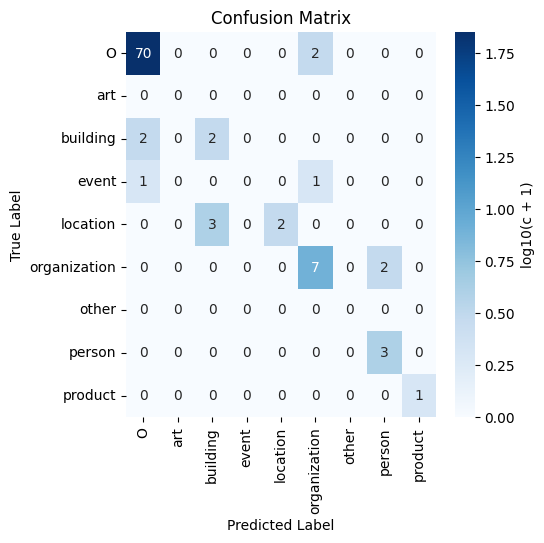

In [ ]:
# Configure strategy and prompt template
predictor_dev.configure(complex_decomposed_technique)

# Retrieve predictions
predictions = predictor_dev.predict()
print(f"Final predictions:\n{predictions}\n")
compute_metrics(predictions, true_labels_dev)

# Testing
We proceed to evaluate all presented techniques, excluding `Decomposed` and `Tool Augmentation` approaches. These were omitted due to their high API request costs and an underwhelming performance in our experimental phase.


In [ ]:
rate_limiter_test = RateLimiter(MAX_RPM_TEST)

predictor_test = NERPredictor(model=CHATBOT_MODEL_GEMINI_TEST,
                              client=client,
                              rate_limiter=rate_limiter_test,
                              label_set=label_set,
                              input_sentences=input_sentences_test)

Executing Sentence: Elin Hilderbrand is an American writer mostly of romance novels.
-- Response: [Entity(token='Elin Hilderbrand', label='person'), Entity(token='American', label='other')]
Executing Sentence: A prototype was fitted in the mid-'60s in a one-off DB5 extended 4" after the doors and driven by Marek personally, and a normally 6-cylinder Aston Martin DB7 was equipped with a V8 unit in 1998.
-- Response: [Entity(token='DB5', label='product'), Entity(token='Marek', label='person'), Entity(token='Aston Martin', label='organization'), Entity(token='DB7', label='product')]
Executing Sentence: He has caught the attention of major publications and media outlets such as CNN, The Huffington Post, Hypebeast, The Guardian, Juxtapoz Magazine, Daily Mail, NRDC, Aljazeera and Hi-Fructose Magazine.
-- Response: [Entity(token='CNN', label='organization'), Entity(token='The Huffington Post', label='organization'), Entity(token='Hypebeast', label='organization'), Entity(token='The Guardian',

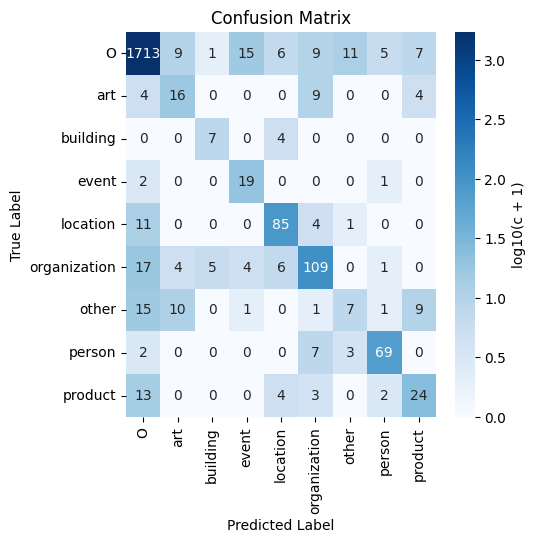

In [ ]:
# Configure strategy and prompt template
predictor_test.configure(vanilla_technique)

# Retrieve predictions
predictions = predictor_test.predict()
print(f"Final predictions:\n{predictions}\n")
compute_metrics(predictions, true_labels_test)

Executing Sentence: Elin Hilderbrand is an American writer mostly of romance novels.
-- Response: ['Elin Hilderbrand', 'American']
-- Response: Okay, I will process the input text, look up the entities, and provide brief descriptions.

Here's a breakdown of the entities and their descriptions:

*   **Elin Hilderbrand:** An American author known for her beach reads, often focusing on romance and set in Nantucket.
*   **American:** Relating to the United States of America.
*   **Romance novels:** A genre of fiction that focuses on the relationship and romantic love between two people, typically with a happy ending.

-- Response: [Entity(token='Elin Hilderbrand', label='person'), Entity(token='American', label='other'), Entity(token='romance novels', label='product')]
Executing Sentence: A prototype was fitted in the mid-'60s in a one-off DB5 extended 4" after the doors and driven by Marek personally, and a normally 6-cylinder Aston Martin DB7 was equipped with a V8 unit in 1998.
-- Respo

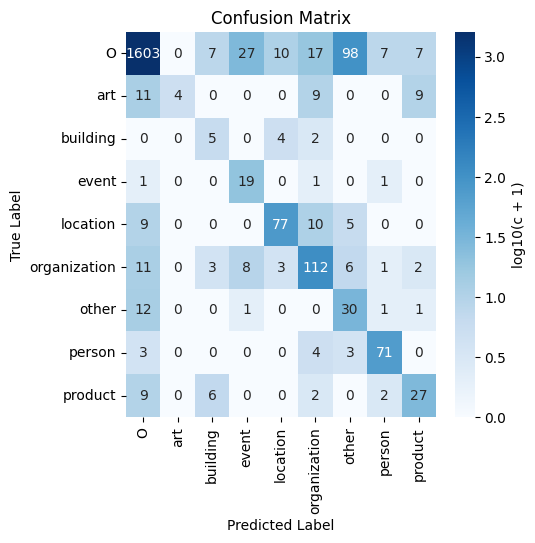

In [ ]:
# Configure strategy and prompt template
predictor_test.configure(vanilla_online_search_technique)

# Retrieve predictions
predictions = predictor_test.predict()
print(f"Final predictions:\n{predictions}\n")
compute_metrics(predictions, true_labels_test)

Executing Sentence: Elin Hilderbrand is an American writer mostly of romance novels.
-- Response: [Entity(token='Elin Hilderbrand', label='person'), Entity(token='American', label='other')]
Executing Sentence: A prototype was fitted in the mid-'60s in a one-off DB5 extended 4" after the doors and driven by Marek personally, and a normally 6-cylinder Aston Martin DB7 was equipped with a V8 unit in 1998.
-- Response: [Entity(token='DB5', label='product'), Entity(token='Aston Martin', label='organization'), Entity(token='DB7', label='product'), Entity(token='V8', label='product')]
Executing Sentence: He has caught the attention of major publications and media outlets such as CNN, The Huffington Post, Hypebeast, The Guardian, Juxtapoz Magazine, Daily Mail, NRDC, Aljazeera and Hi-Fructose Magazine.
-- Response: [Entity(token='CNN', label='organization'), Entity(token='The Huffington Post', label='organization'), Entity(token='Hypebeast', label='organization'), Entity(token='The Guardian', l

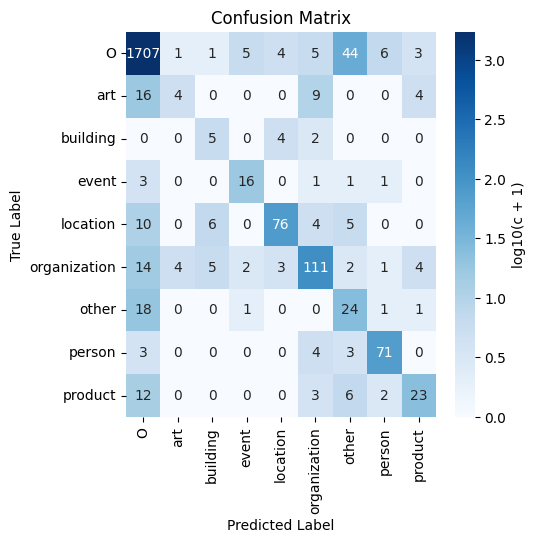

In [ ]:
# Configure strategy and prompt template
predictor_test.configure(vanilla_chain_of_thought_technique)

# Retrieve predictions
predictions = predictor_test.predict()
print(f"Final predictions:\n{predictions}\n")
compute_metrics(predictions, true_labels_test)

Executing Sentence: Elin Hilderbrand is an American writer mostly of romance novels.
-- Response: [Entity(token='Elin Hilderbrand', label='person'), Entity(token='American', label='other')]
-- Response: [Entity(token='Elin Hilderbrand', label='person'), Entity(token='American', label='other')]
Executing Sentence: A prototype was fitted in the mid-'60s in a one-off DB5 extended 4" after the doors and driven by Marek personally, and a normally 6-cylinder Aston Martin DB7 was equipped with a V8 unit in 1998.
-- Response: [Entity(token='DB5', label='product'), Entity(token='Aston Martin', label='organization'), Entity(token='DB7', label='product')]
-- Response: [Entity(token='DB5', label='product'), Entity(token='Aston Martin', label='organization'), Entity(token='DB7', label='product')]
Executing Sentence: He has caught the attention of major publications and media outlets such as CNN, The Huffington Post, Hypebeast, The Guardian, Juxtapoz Magazine, Daily Mail, NRDC, Aljazeera and Hi-Fruc

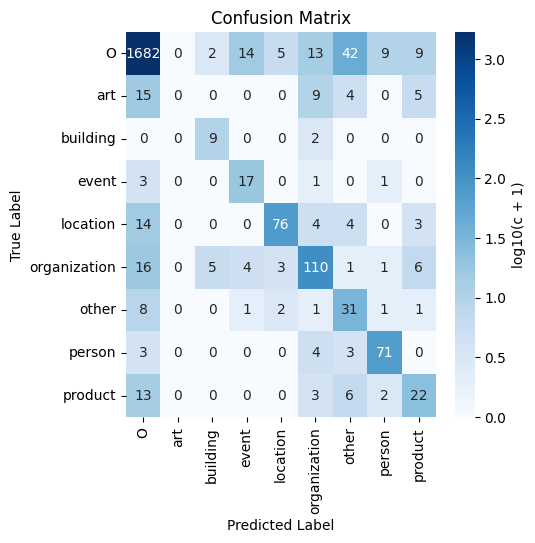

In [ ]:
# Configure strategy and prompt template
predictor_test.configure(vanilla_iterative_refinement_technique)

# Retrieve predictions
predictions = predictor_test.predict()
print(f"Final predictions:\n{predictions}\n")
compute_metrics(predictions, true_labels_test)

Executing Sentence: Elin Hilderbrand is an American writer mostly of romance novels.
-- Response: [Entity(token='Elin Hilderbrand', label='person'), Entity(token='American', label='location')]
Executing Sentence: A prototype was fitted in the mid-'60s in a one-off DB5 extended 4" after the doors and driven by Marek personally, and a normally 6-cylinder Aston Martin DB7 was equipped with a V8 unit in 1998.
-- Response: [Entity(token='DB5', label='product'), Entity(token='Marek', label='person'), Entity(token='Aston Martin DB7', label='product')]
Executing Sentence: He has caught the attention of major publications and media outlets such as CNN, The Huffington Post, Hypebeast, The Guardian, Juxtapoz Magazine, Daily Mail, NRDC, Aljazeera and Hi-Fructose Magazine.
-- Response: [Entity(token='CNN', label='organization'), Entity(token='The Huffington Post', label='organization'), Entity(token='Hypebeast', label='organization'), Entity(token='The Guardian', label='organization'), Entity(token

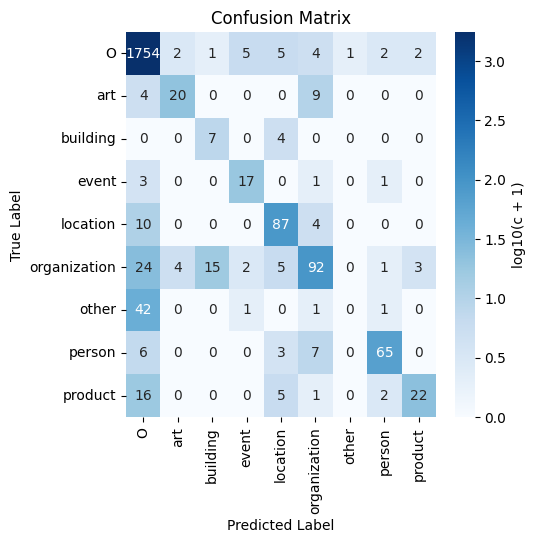

In [ ]:
# Configure strategy and prompt template
predictor_test.configure(few_shot_technique)

# Retrieve predictions
predictions = predictor_test.predict()
print(f"Final predictions:\n{predictions}\n")
compute_metrics(predictions, true_labels_test)

# Discussion

### **Results**
<table>
<tr>
<th colspan="5">Token Level Evaluation</th>
</tr>
<tr>
<th>Technique</th>
<th>Accuracy</th>
<th>Precision</th>
<th>Recall</th>
<th>F1 Score</th>
</tr>
<tr><td>Vanilla</td><td>0.8961</td><td>0.9005</td><td>0.8961</td><td>0.8959</td></tr>
<tr><td>Vanilla + Online search</td><td>0.8616</td><td>0.9075</td><td>0.8616</td><td>0.8750</td></tr>
<tr><td>Vanilla + Chain of Thought</td><td>0.9009</td><td>0.9070</td><td>0.9009</td><td>0.9013</td></tr>
<tr><td>Vanilla + Iterative refinement</td><td>0.8925</td><td>0.8948</td><td>0.8925</td><td>0.8917</td></tr>
<tr><td>Few-shot</td><td>0.9049</td><td>0.8940</td><td>0.9049</td><td>0.8970</td></tr>
</table>
=================================
<table>
<tr>
<th colspan="5">Boundary Level Evaluation</th>
</tr>
<tr>
<th>Technique</th>
<th>Accuracy</th>
<th>Precision</th>
<th>Recall</th>
<th>F1 Score</th>
</tr>
<tr><td>Vanilla</td><td>0.4854</td><td>0.4372</td><td>0.4854</td><td>0.4543</td></tr>
<tr><td>Vanilla + Online search</td><td>0.4173</td><td>0.3656</td><td>0.4173</td><td>0.3748</td></tr>
<tr><td>Vanilla + Chain of Thought</td><td>0.4496</td><td>0.4231</td><td>0.4496</td><td>0.4273</td></tr>
<tr><td>Vanilla + Iterative refinement</td><td>0.4556</td><td>0.3956</td><td>0.4556</td><td>0.4192</td></tr>
<tr><td>Few-shot</td><td>0.5033</td><td>0.4998</td><td>0.5033</td><td>0.4978</td></tr>
</table>

The following analysis is simply based on 1 test run, therefore the next considerations are just hypotheses:
 - Performance gap: token-level evaluation shows consistently high performance (89-90%) while boundary-level evaluation is much lower (37-50%), possibly indicating that the model struggles with precise entity boundary detection.

-  Few-shot learning: few-shot learning achieves the best boundary-level performance (F1: 0.4978) and second-best token-level performance; perhaps making it the most balanced and practical approach for real-world NER applications.

- Online Search considerations: adding online search actually degrades performance across both evaluation levels, suggesting that external information may introduce noise rather than helpful context for this NER task.


### **Issues encountered**
- For metrics computation, sequence alignment between the input sentence tokens and the entities generated by the LLM
- LLM had a hard time detecting the correct span boundary
- Daily API requests limit
- Accurate reconstruction of the sentence from the tokens

More details can be found inside the notebook.


### **Things we have noticed**
- When looking for possible LLM to use we noticed that there are very few free  options.
- The label order in which we feed the LLM and prompt spacing is impacting the model performace across all techniques.
- General purpose LLM works better in a general purpose dataset; we tested our approach with the [finer dataset](https://arxiv.org/abs/2203.06482) and resulted in very poor performance in a zero-shot setting, since the LLM would have required much more expertise on the finance domain.

### **Future work**

This project is clearly a proof of concept, and as such could be improved in many ways:
1. Try new techniques (e.g. decomposed + iterative refinement , self consistency, ...)
2. Make use of fine-tuning
3. Find better methodology to align predicted labels to gold labels, making sure the labels correctly reflect their place in the sentence
4. Test the presented techniques with state-of-the-art LLM
5. Test with no API calls limitations
6. Run a statistical hypotheses test

## References

This work was based on publicly avaiable informations. In particular to:
- [Gemini API](https://ai.google.dev/gemini-api/docs/models?hl=it)
- [Empirical Study of Zero-Shot NER with ChatGPT](https://arxiv.org/abs/2310.10035)
- [Few-Nerd dataset](https://arxiv.org/abs/2105.07464)
- [EvoPrompt: Evolving Prompts for Enhanced Zero-Shot Named Entity Recognition with Large Language Models](https://aclanthology.org/2025.coling-main.345/)
- [Chain of Thought Prompting](https://www.codecademy.com/article/chain-of-thought-cot-prompting)